# Análisis Topológico de Trayectorias Geolife


Este notebook contiene el flujo completo para el análisis de trayectorias usando herramientas de Topological Data Analysis (TDA) sobre el dataset Geolife.

### Objetivos:
- Leer múltiples trayectorias en formato `.plt`
- Generar nubes de puntos 3D (latitud, longitud, altitud)
- Calcular diagramas de persistencia
- Extraer descriptores topológicos
- Visualizar trayectorias y patrones
- Comparar TDA con técnicas clásicas de análisis de trayectorias


## 1. Carga de Trayectorias Geolife

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import MinMaxScaler
from shapely import wkt

folder = "C:\\Users\\Krlo\\OneDrive - Universidad Politécnica de Madrid\\Escritorio\\TFG\\Codigo\\Datos\\038\\Trajectory" 
files = glob.glob(os.path.join(folder, "*.plt"))

def read_trajectory(filepath):
    df = pd.read_csv(filepath, skiprows=6, header=None)
    df.columns = ['lat', 'lon', 'unused1', 'alt', 'time_float', 'date', 'time']
    return df[['lat', 'lon', 'alt']].dropna().values

trajectories = [read_trajectory(f) for f in files if os.path.getsize(f) > 500]
print(f"Trayectorias cargadas: {len(trajectories)}")

Trayectorias cargadas: 110


## 2. Visualización de Trayectorias en 3D

In [2]:
from gtda.plotting import plot_point_cloud
i = 0
plot_point_cloud(trajectories[i])


## 3. Diagramas de Persistencia

In [4]:

from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from sklearn.cluster import KMeans


homology_dimensions = [0, 1, 2]
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=15,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(trajectories)
plot_diagram(diagrams_basic[0])



## 4. Extracción de Descriptores Topológicos

In [ ]:
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_point_cloud
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)


pe = PersistenceEntropy(normalize=True)
features = pe.fit_transform(diagrams_basic)
plot_point_cloud(features)
plt.show()

features = pe.fit_transform(diagrams_basic)  # features: n_samples x 1
pipe = make_mapper_pipeline(
    filter_func=Projection(columns=[0,1,2]), 
    cover=CubicalCover(n_intervals=10, overlap_frac=0.3),
    clusterer=DBSCAN(),
    verbose=True
)
graph = pipe.fit_transform(features)

fig = plot_static_mapper_graph(pipe, features)
fig.show()


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


## 5. Análisis y Comparación de Trayectorias

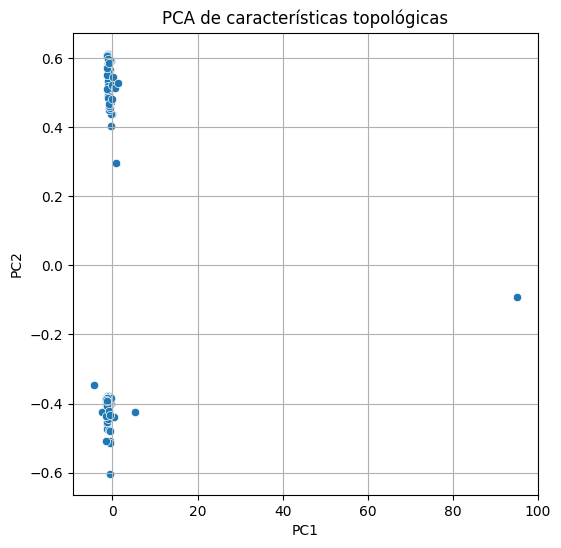

In [21]:

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1])
plt.title("PCA de características topológicas")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
